In [26]:
from tqdm import tqdm
import requests, re, html_text
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from cleantext import clean
import pickle
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import time
import numpy as np

# Embeddings

In [2]:
URL = "https://en.wikipedia.org/w/api.php"
TITLE = "Wikipedia:Lists of popular pages by WikiProject"
PARAMS = {
    'action': "parse",
    'page': TITLE,
    'prop': 'wikitext',
    'section': 1,
    'format': "json"
}
S = requests.Session()
res = S.get(url=URL, params=PARAMS)
data = res.json()
wikitext = data['parse']['wikitext']['*']
lines = wikitext.split('|-')
popular_pages = []
for line in lines:
        entry = line.split("|")        
        popular_list = re.sub("\[|\]|\n", '', entry[1])
        subject = re.sub("\[|\]|\n", '', entry[-1])
        if 'Computing' in subject:
            popular_pages.append(popular_list)
entries = []
for pages in tqdm(popular_pages):
    PARAMS = {
        'action': "parse",
        'page': pages,
        'prop': 'wikitext',
        'section': 1,
        'format': "json"
    }
    
    res = S.get(url=URL, params=PARAMS)
    data = res.json()
    
    wikitext = data['parse']['wikitext']['*']
    lines = wikitext.split('|-')
    for line in lines:
            entry = line.split("|")
            if len(entry) < 3:
                continue
            page_title = re.sub("\[|\]|\n", '', entry[2])
            importance = re.sub("\[|\]|\n", '', entry[-1])
            if importance != 'Low' and importance != 'Unknown':
                entries.append(page_title[1:].replace('%E2%80%93', '-').replace('&#039;', "'"))

100%|███████████████████████████████████████████| 14/14 [00:18<00:00,  1.32s/it]


In [3]:
with open('word_dict.pickle', 'rb') as handle:
    word_dict = pickle.load(handle)
common_subtopics = set(word_dict.keys())

In [4]:
len(entries)

4470

In [7]:
dataset = defaultdict(list)
for i, entry in tqdm(enumerate(entries)):
    TITLE = entry
    PARAMS = {
    'action': "parse",
    'page': TITLE,
    'prop': 'sections',
    'format': "json"
    }
    res = S.get(url=URL, params=PARAMS)
    data = res.json()
    try:
        data = data['parse']['sections']
    except:
        continue
    content_list = []
    for idx, sections in enumerate(data):
        if int(sections['toclevel']) == 1:
            if sections['anchor'] in common_subtopics:
                content_list.append((idx+1, sections['anchor']))
                
    if content_list == []:
        continue
    for idx, topic in content_list:
        PARAMS = {
            'action': "parse",
            'page': TITLE,
            'section': idx,
            'prop': 'text',
            'format': "json"
        }
        res = S.get(url=URL, params=PARAMS)
        data = res.json()
        data_split = re.split("<p>", str(list(data['parse']['text'].values())[0]))
        data = " ".join(data_split[1:])
        text = html_text.extract_text(data, guess_layout=False)
        sentence_count = text.split(".")
        if len(sentence_count) > 15:
            text = '.'.join(sentence_count[:15])
            
        text = re.sub('\[\d+\]|\[ [a-z] \]', "", text)
        text = re.sub('\s+',' ',text)
        words = clean(re.sub(r'_', ' ', text)).split(" ")
    
        stop_words = nltk.corpus.stopwords.words("english")
        text_filtered = [word for word in words if not word in stop_words]
        stemmer = WordNetLemmatizer()
        text_stemmed = ' '.join([stemmer.lemmatize(y) for y in text_filtered])
        if len(text) != 0:
            dataset[topic].append(text_stemmed)

4470it [1:26:36,  1.16s/it]


In [8]:
len(dataset)

146

In [43]:
start = time.time()
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
print("Model initializaiton: ", time.time() - start)

Model initializaiton:  4.755447149276733


In [44]:
dataset_emb = defaultdict()

In [45]:
for topic, paras in tqdm(dataset.items()):
    dataset_emb[topic] = np.average(model.encode(paras), 0)

 99%|████████████████████████████████████████▍| 146/148 [28:01<00:05,  2.91s/it]/Users/arpan/Documents/FORWARD_LAB/fwd_venv/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/arpan/Documents/FORWARD_LAB/fwd_venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████| 148/148 [28:01<00:00, 11.36s/it]


In [47]:
with open('clusters.pickle', 'rb') as handle:
    clusters = pickle.load(handle)
clustered_subtopics = list(clusters.values())

In [48]:
labels = []
for k, v in dataset_emb.items():
    for i in range(len(clustered_subtopics)):
        if k in set(clustered_subtopics[i]):
            labels.append(i)

In [49]:
len(labels)

146

In [50]:
embs = list(dataset_emb.values())[:-2]

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x = pca.fit_transform(embs)[:,0]
y = pca.fit_transform(embs)[:,1]

In [52]:
import seaborn as sns

<AxesSubplot:>

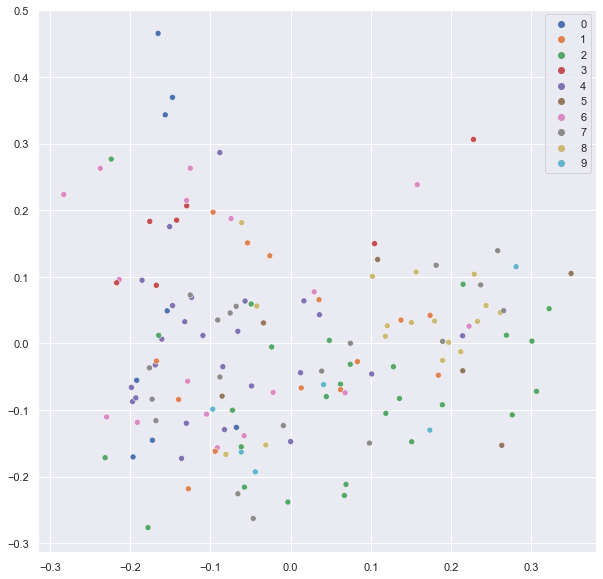

In [53]:
sns.set(style="darkgrid", rc = {'figure.figsize':(10,10)})
sns.scatterplot(x=x, y=y, hue=labels, palette="deep")

In [54]:
# cluster usiing this ^

In [55]:
# remove all the nouns from the text